## Auxotrophic Growth of ADP1 ISx strains on Arginine
This is a revisit of analytical framework prompted by:
1. prep for the MBP MidTerm Progress Report
2. Keith's recent slack with some FoldIncrease calculations

### Quick Notes
- I've been approaching my calculations with the idea that two main functions should suffice for my theoretical modeling of Arg-aux growth:
    1. x_Arg(OD600_init, abundance_CGP_in_CDW, consts) 
    2. OD600(x_Arg, consts)
- I've highlighted the differences from Keith's assumptions in values of constants
- I closely recapitulated Keith's fold increase calculations (11/05/2024)
- I realized that the `[Arg] from BM w/CGP` curves I've been using need a bit more explanation - at least graphically:
    - I'm using the OD600 scale for both OD600_init for `[Arg] from BM w/CGP` and OD600_final for the yield curves.
- I've been constructing the combined unit Yield as OD_phaseII from OD_phaseI, that naming is confusing because OD_phaseII is independent of OD_phaseI and is solely dependent on starting OD in phaseII and CGP(%CDW) from PhaseI.

In [1]:
from functools import partial

from IPython.display import display

from sympy import symbols, Eq, plot, Function, N, Piecewise, log, lambdify
from sympy.physics.units.prefixes import micro
from sympy.physics.units import au, gram, liter, milliliter, mol

In [2]:
# numeric rounding to 3 sig figs
N3 = partial(N, n=3)

# additional units
molar = mol / liter
wv_perc = gram / (100 * milliliter)

In [3]:
# symbols (restricted to real values)
Real = partial(symbols, real=True)

# species
CGP, Arg, Asp, prot = Real('CGP, Arg, Asp, prot')

# abundances (mass ratios)
ab_Arg_in_prot = Real(r'abundance_{\frac{Arg}{prot}}')
ab_Arg_in_CGP = Real(r'abundance_{\frac{Arg}{CGP}}')
ab_Asp_in_CGP = Real(r'abundance_{\frac{Asp}{CGP}}')
ab_Arg_in_CDW = Real(r'abundance_{\frac{Arg}{CDW}}')
ab_CGP_in_CDW = Real(r'abundance_{\frac{CGP}{CDW}}')
ab_prot_in_CDW = Real(r'abundance_{\frac{prot}{CDW}}')
ab_CDW_per_OD600 = Real(r'ratio_{\frac{CDW}{OD600}}')

# masses
m_Arg, m_CGP, CDW = Real('m_{Arg}, m_{CGP}, CDW')

# molar weights
mw_Arg, mw_Asp = Real('mw_{Arg}, mw_{Asp}')

# concentrations (molar)
x = Real('x')
x_Arg = Real(r'x_{Arg}')
x_CGP = Real(r'x_{CGP}')

# optical density
OD_initial, OD_final, OD_delta = Real(r'OD600_{init}, OD600_{final}, OD600_{delta}')

# yields
Y_OD_from_x = Real(r'Y_{\frac{OD600}{x}}')
Y_OD_from_Arg_theor = Real(r'Y_{\frac{OD600}{Arg}_{theoretical}}')
Y_OD_from_Arg_exper = Real(r'Y_{\frac{OD600}{Arg}_{experimental}}')
Y_ODp2_from_ODp1 = Real(r'Y_{\frac{OD600_{phase2}}{OD600_{phase1}}}')
Y_CDWp2_from_CDWp1 = Real(r'Y_{\frac{CDW_{phase2}}{CDW_{phase1}}}')

# fold change (increase)
fold_chg_biomass = Real('FoldChange_{biomass}')

In [4]:
# FIXME - differs from Keith's assumptions

consts = {
    # molar weights
    mw_Arg: 174.2 * gram / mol,
    mw_Asp: 133.1 * gram / mol,

    # abundances
    ab_Arg_in_CGP: 0.60,  # FIXME accounting for one H2O loss 174.2 / (174.2 + 133.1 - 18)
    # ab_CGP_in_CDW: 0.10,  # working assumption (previously considered conservative)
    ab_Arg_in_prot: 0.05,  # 1/20 of all proteins (confirmed in cheminfo.ipynb)
    ab_prot_in_CDW: 0.50,  # 1/2 of cell dry weight presumed to be proteins

    # conversions FIXME based on https://bionumbers.hms.harvard.edu/bionumber.aspx?id=109838&ver=2 
    ab_CDW_per_OD600: .33 * (gram / liter) / au,
}

In [5]:
# linear relationship between OD600 (optical density) and x (molar concentration)
eq_OD_final = Eq(OD_final, OD_delta + OD_initial)
eq_OD_delta = Eq(OD_delta, x * Y_OD_from_x)

display(eq_OD_final, eq_OD_delta)

Eq(OD600_{final}, OD600_{delta} + OD600_{init})

Eq(OD600_{delta}, Y_{\frac{OD600}{x}}*x)

In [6]:
(eq_fold_diff := Eq(fold_chg_biomass, (OD_initial + OD_delta) / OD_initial))

Eq(FoldChange_{biomass}, (OD600_{delta} + OD600_{init})/OD600_{init})

### Theoretical arginine demand by proteome (growth limiting)

This is a theoretical upper bound on arginine-auxotrophic growth, as we expect the highest priority for arginine utilization to be expression of the proteome.

In [7]:
eq_abundance_arg_cdw = Eq(ab_Arg_in_CDW, ab_prot_in_CDW * ab_Arg_in_prot)
consts[ab_Arg_in_CDW] = N3(eq_abundance_arg_cdw.rhs.subs(consts))

display(eq_abundance_arg_cdw, consts[ab_Arg_in_CDW])

Eq(abundance_{\frac{Arg}{CDW}}, abundance_{\frac{Arg}{prot}}*abundance_{\frac{prot}{CDW}})

0.0250

In [8]:
eq_Y_OD_from_arg = Eq(Y_OD_from_Arg_theor, mw_Arg / (ab_CDW_per_OD600 * ab_Arg_in_CDW))
consts[Y_OD_from_Arg_theor] = N3(eq_Y_OD_from_arg.rhs.subs(consts))

display(eq_Y_OD_from_arg, consts[Y_OD_from_Arg_theor])

Eq(Y_{\frac{OD600}{Arg}_{theoretical}}, mw_{Arg}/(abundance_{\frac{Arg}{CDW}}*ratio_{\frac{CDW}{OD600}}))

2.11e+4*astronomical_unit*liter/mole

In [9]:
(eq_OD_delta_x_Arg__theor := eq_OD_delta.subs({x: x_Arg, Y_OD_from_x: consts[Y_OD_from_Arg_theor]}))

Eq(OD600_{delta}, 2.11e+4*astronomical_unit*liter*x_{Arg}/mole)

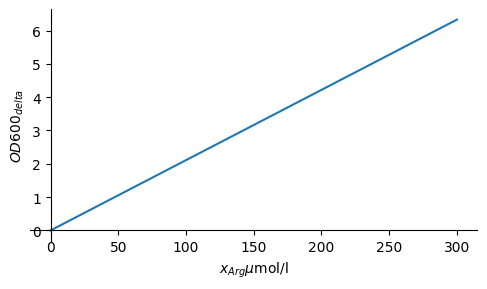

In [10]:
# plot of theoretical OD600 from x_Arg
plot(
    eq_OD_delta_x_Arg__theor.rhs.subs(consts) * (micro * mol / liter) / au,
    (x_Arg, 0, 300),
    xlabel=x_Arg * micro * mol / liter,
    ylabel=OD_delta,
    size=(5, 3),
)

### Accumulated CGP as source of Arginine

ALE Phases with auxotrophic stains:

- Phase I - inoculation from pre-culture, growth and accumulation of CGP
- Phase II - inoculation from cultures from Phase I, growth limited by Arg from 

CGP is accumulated in Phase I and consumed in Phase II of ALE.

### Modeling x_Arg (arginine concentration) in the volume of culture medium

In [11]:
# we know how to estimate OD based on Arg concentration, so we need a function to predict Arg concentration:
Function(x_Arg)(OD_initial, ab_CGP_in_CDW)

x_{Arg}(OD600_{init}, abundance_{\frac{CGP}{CDW}})

In [12]:
eq_x_Arg_from_OD_init = Eq(x_Arg, OD_initial * ab_CDW_per_OD600 * ab_CGP_in_CDW * ab_Arg_in_CGP / mw_Arg)
eq_x_Arg_from_OD_init

Eq(x_{Arg}, OD600_{init}*abundance_{\frac{Arg}{CGP}}*abundance_{\frac{CGP}{CDW}}*ratio_{\frac{CDW}{OD600}}/mw_{Arg})

In [13]:
# lower bound on x_Arg from 0.05 ODinit and 10 CGP(%CDW) (realistic)
N3(eq_x_Arg_from_OD_init.subs({OD_initial: .05 * au, ab_CGP_in_CDW: 0.10}).subs(consts))

Eq(x_{Arg}, 5.68e-6*mole/liter)

In [14]:
# upper bound on x_Arg from 0.20 ODinit and 60 CGP(%CDW) (supremely optimistic)
N3(eq_x_Arg_from_OD_init.subs({OD_initial: .20 * au, ab_CGP_in_CDW: 0.60}).subs(consts))

Eq(x_{Arg}, 0.000136*mole/liter)

In [15]:
# combine OD600 and x_Arg functions (example)
N3(eq_OD_delta_x_Arg__theor.rhs.subs({
    x_Arg: eq_x_Arg_from_OD_init.rhs.subs({
        OD_initial: .1 * au,
        ab_CGP_in_CDW: .25,
    })
}).subs(consts))

0.6*astronomical_unit

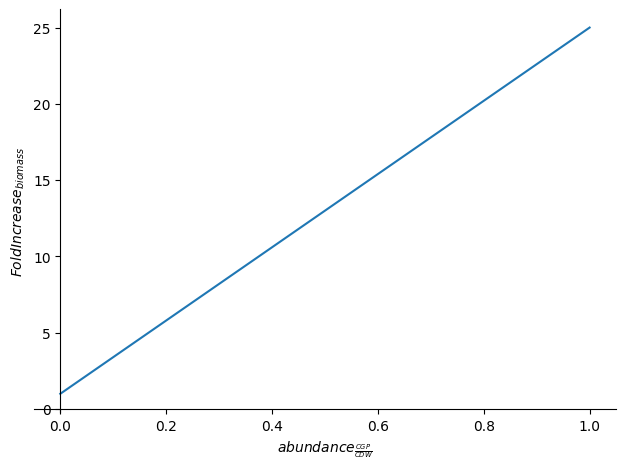

In [16]:
# plot FoldChange_OD600 over CGP(%CDW) :: should be equivalent to Keith's gCDW, since linearly related
plot(
    eq_fold_diff.rhs.subs({
        OD_delta: eq_OD_delta_x_Arg__theor.rhs.subs({
            x_Arg: eq_x_Arg_from_OD_init.rhs,
        })
    }).subs({OD_initial: .05 * au}).subs(consts),
    (ab_CGP_in_CDW, 0, 1),
    ylabel=symbols('FoldIncrease_{biomass}'),
)

### Experimental Results

In [ ]:
# exp007 - ∆argBR ∆astA

In [37]:
# exp011 - ∆argBR ∆astA ∆cphAI
(eq_OD_delta_x_Arg__exp011_KSF111 := Eq(OD_delta, Piecewise(
    # pre-saturation
    (.448 / 50 * x_Arg, x_Arg <= 50),
    # post-saturation
    (.448, x_Arg > 50),
)))

Eq(OD600_{delta}, Piecewise((0.00896*x_{Arg}, x_{Arg} <= 50), (0.448, True)))

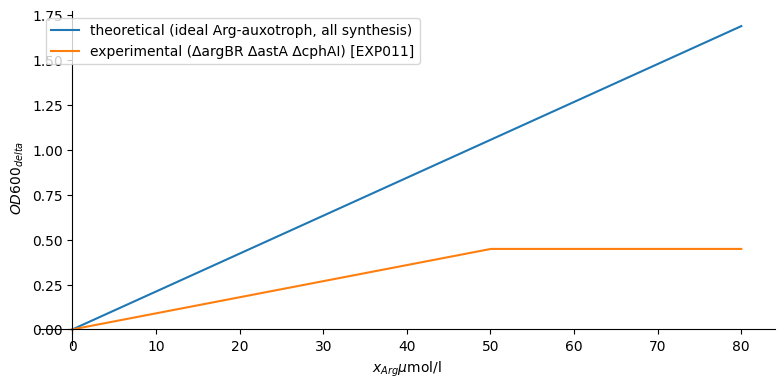

In [38]:
plot(
    # theoretical
    eq_OD_delta_x_Arg__theor.subs(consts).rhs * (micro * mol / liter) / au,
    # exp011 (KSF111 - ∆argBR ∆astA ∆cphAI)
    eq_OD_delta_x_Arg__exp011_KSF111.rhs,
    # exp007 (KSF230 - ∆argB ∆cphAI)
    # exp007 (KSF230+ - ∆argBR ∆cphAI)
    
    # range
    (x_Arg, 0, 80),
    # plot options
    xlabel=x_Arg * micro * mol / liter,
    ylabel=OD_delta,
    label=(
        'theoretical (ideal Arg-auxotroph, all synthesis)',
        'experimental (∆argBR ∆astA ∆cphAI) [EXP011]',
    ),
    legend=True,
    size=(8, 4),
)

In [ ]:
# proposed loading (need much higher starting OD of .1 au if we assume the most conservative 10% CGP.
# FIXME this is where we really 
N3(eq_x_Arg_from_OD_init.subs({OD_initial: .1 * au, ab_CGP_in_CDW: 0.10}).subs(const))

In [ ]:
# proposed OD_init | assuming CGP/CDW of 1/10
# expected additional OD, based on exp011
eq_OD_from_Arg

In [ ]:
# fold change
N3((.5 + .1) / .1)

In [ ]:
# number of cell doublings
N3(log(6, 2))

In [ ]:
eq_OD_from_Arg.subs({x_Arg: eq_x_Arg_from_OD_init.rhs}).subs(
    {OD_initial: .1 * au, ab_CGP_in_CDW: .1}
)